### Libraries

In [42]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from math import floor
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

from collections.abc import Iterable
import os

from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface, NWBData
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import scipy.io as sio
import skimage.io as skio
from tifffile import TiffFile

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries, SegmentationLabels

### Dataset Preprocessing

In [ ]:
# Read NWB files to get image, channels...
def convertNWB(path):   
    with NWBHDF5IO(path, mode='r', load_namespaces=True) as io:
        read_nwbfile = io.read()
        print(read_nwbfile) # you can print the nwbfile after reading to see the contents of the file
        #print(read_nwbfile.processing['CalciumActivity'])
        print(read_nwbfile.processing['NeuroPAL'])
        #print(read_nwbfile.processing['ProcessedImage'])
        subject = read_nwbfile.subject #get the metadata about the experiment subject
        growth_stage = subject.growth_stage
        image = read_nwbfile.acquisition['NeuroPALImageRaw'].data[:] #get the neuroPAL image as a np array
        channels = read_nwbfile.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
        im_vol = read_nwbfile.acquisition['NeuroPALImageRaw'].imaging_volume #get the metadata associated with the imaging acquisition
        seg = read_nwbfile.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:] #get the locations of neuron centers
        labels = read_nwbfile.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
        optchans = im_vol.optical_channel_plus[:] #get information about all of the optical channels used in acquisition
        #proc_image = read_nwbfile.processing['ProcessedImage']['ProcessedImage'].data[:] #get the pre-processed image
        #calcium_frames = read_nwbfile.acquisition['CalciumImageSeries'].data[0:15, :,:,:] #load the first 15 frames of the calcium images
        #fluor = read_nwbfile.processing['CalciumActivity']['SignalDFoF']['SignalCalciumImResponseSeries'].data[:]
        #rois = read_nwbfile.processing['CalciumActivity']['SignalDFoF']['SignalCalciumImResponseSeries'].get_roi_response_series()
        #calc_seg = read_nwbfile.processing['CalciumActivity']['CalciumSeriesSegmentation']['Seg_tpoint_0'].voxel_mask[:]

        read_nwbfile
    return image, channels

In [ ]:
def get_datasets(path):
    rgbdata=[] # RGB images
    graydata=[] # Gray images with 3 channels
    graydata_z=[] # Gray images with 3 channels + z
    graydata_single=[] # Gray images with 1 channel
    
    print('Number of nwb: '+str(len(os.listdir(path)))+'\n')
    
    for files in os.listdir(path):
        print(files)
        
        image, channels = convertNWB(path+files) 
        x = np.array(image).shape[0]
        y = np.array(image).shape[1]
        z = np.array(image).shape[2]
        print("Number of slices: "+str(z))
        
        for i in range(z):
            dgray = np.zeros((128, 128, 3))
            dgray_single = np.zeros((128, 128, 1))
            dgray_z = np.zeros((128, 128, 4))
            drgb = np.zeros((128, 128, 3))
            for j in range(x):
                for l in range(y):
                    xr = int(j*(128/x))
                    yr = int(l*(128/y))
                    zr = i/z
                    
                    drgb[xr][yr][0] = image[j][l][i][channels[0]]/65535 #R
                    drgb[xr][yr][1] = image[j][l][i][channels[1]]/65535 #G
                    drgb[xr][yr][2] = image[j][l][i][channels[2]]/65535 #B
                    
                    gray = (drgb[xr][yr][0]*299+(drgb[xr][yr][1]*587)+(drgb[xr][yr][2]*114)) / 1000
                    dgray[xr][yr][0] = gray
                    dgray[xr][yr][1] = gray
                    dgray[xr][yr][2] = gray
                    
                    dgray_z[xr][yr][0] = gray
                    dgray_z[xr][yr][1] = gray
                    dgray_z[xr][yr][2] = gray
                    dgray_z[xr][yr][3] = zr
                    
                    dgray_single[xr][yr][0] = gray
                    
            rgbdata.append(drgb)
            graydata.append(dgray)
            graydata_z.append(dgray_z)
            graydata_single.append(dgray_single)
            
    return rgbdata, graydata, graydata_z, graydata_single

In [6]:
rgbdata, graydata, graydata_z, graydata_single = get_datasets('./data/nwbdata/')

Number of nwb: 25

sub-11-YAaLR_ophys.nwb


c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


root pynwb.file.NWBFile at 0x3060950026512
Fields:
  acquisition: {
    NeuroPALImageRaw <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolume'>
  }
  devices: {
    Spinning disk confocal <class 'pynwb.device.Device'>
  }
  experiment_description: NeuroPAL whole-brain structural images
  experimenter: ['Yemini, Eviatar']
  file_create_date: [datetime.datetime(2024, 2, 26, 15, 34, 19, 4261, tzinfo=tzoffset(None, -28800))]
  identifier: 11_YAaLR
  imaging_planes: {
    NeuroPALImVol <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>
  }
  institution: Columbia University
  lab: Hobert lab
  processing: {
    NeuroPAL <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['NeuroPAL: A Multicolor Atlas for Whole-Brain Neuronal Identification in C. elegans']
  session_description: C. elegans head NeuroPAL
  session_start_time: 2021-01-07 00:00:00-08:00
  subject: subject abc.CElegansSubject at 0x3061020947216
Fields:
  age__reference: b

### Save and Load npy files

In [ ]:
with open('graydataset.npy', 'wb') as f:
    np.save(f, graydata)

In [2]:
graydata = np.load('data/graydataset.npy')

In [80]:
with open('rgbdataset.npy','wb') as f:
    np.save(f, rgbdata)

In [3]:
rgbdata = np.load('data/rgbdataset.npy')

In [4]:
(np.array(graydata).shape, np.array(rgbdata).shape)

((1072, 128, 128, 3), (1072, 128, 128, 3))

In [20]:
graydata3 = graydata*3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


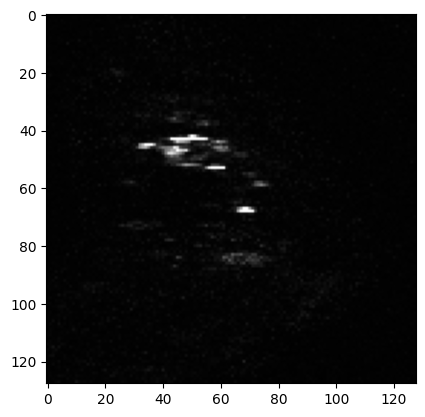

In [21]:
plt.imshow(graydata3[10])
plt.show()

In [24]:
# Train-Test split 90:10
train_test_split = int(len(graydata)*0.9)

train_gray_image = graydata[:train_test_split]
test_gray_image = graydata[train_test_split:]
train_rgb_image = rgbdata[:train_test_split]
test_rgb_image = rgbdata[train_test_split:]

In [25]:
train_gray_image_3 = graydata3[:train_test_split]
test_gray_image_3 = graydata3[train_test_split:]

In [16]:

train_gray_image_z = graydata_z[:train_test_split]
test_gray_image_z = graydata_z[train_test_split:]

train_gray_image_single = graydata_single[:train_test_split]
test_gray_image_single = graydata_single[train_test_split:]

NameError: name 'graydata_z' is not defined

In [17]:
np.array(train_gray_image).shape

(964, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


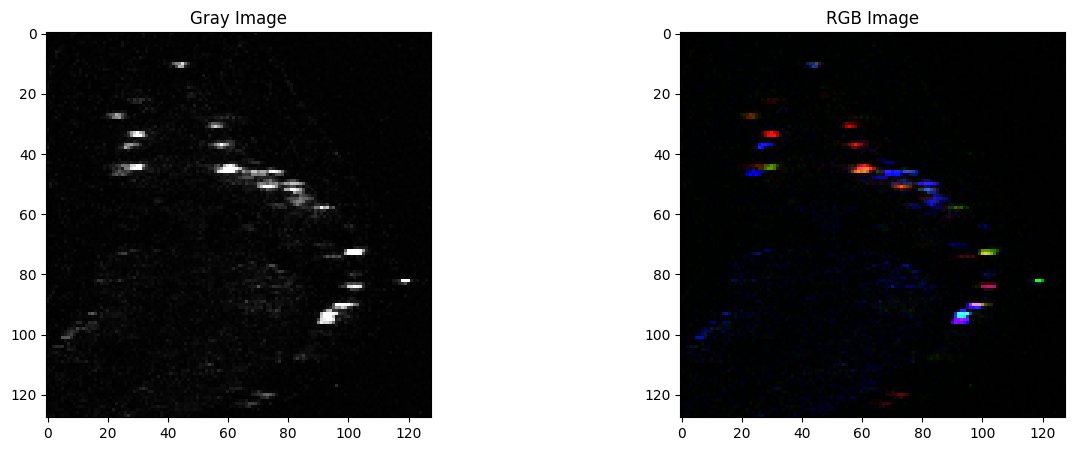

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plot the pdf, cdf & image before equalize
ax1.set_title("Gray Image")
ax1.imshow(graydata3[20])
ax2.set_title("RGB Image")
ax2.imshow(rgbdata[20])
plt.show()

In [27]:
class VoxelColorDataset(Dataset):
    def __init__(self, graydata, rgbdata, transform=None):
        """
        Args:
        - data: Pandas DataFrame or Tensor containing columns for input features and targets.
        - transform: Optional transformations to apply to input features.
        """
        self.inputs = graydata
        self.targets = rgbdata  # Target values
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        
        # Apply optional transformations
        if self.transform:
            x = self.transform(x)

        return x, y


In [28]:
# grayscale with 3 channels
train_dataset = VoxelColorDataset(graydata=train_gray_image, rgbdata=train_rgb_image)
test_dataset = VoxelColorDataset(graydata=test_gray_image, rgbdata=test_rgb_image)

train_dataset_3 = VoxelColorDataset(graydata=train_gray_image_3, rgbdata=train_rgb_image)
test_dataset_3 = VoxelColorDataset(graydata=test_gray_image_3, rgbdata=test_rgb_image)

# grayscale with 3 channels + z axis = 4
train_dataset_z = VoxelColorDataset(graydata=train_gray_image_z, rgbdata=train_rgb_image)
test_dataset_z = VoxelColorDataset(graydata=test_gray_image_z, rgbdata=test_rgb_image)

# grayscale with 1 channel
train_dataset_single = VoxelColorDataset(graydata=train_gray_image_single, rgbdata=train_rgb_image)
test_dataset_single = VoxelColorDataset(graydata=test_gray_image_single, rgbdata=test_rgb_image)

NameError: name 'train_gray_image_z' is not defined

In [29]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

train_loader_3 = DataLoader(train_dataset_3, batch_size=8, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=8, shuffle=True)

train_loader_z = DataLoader(train_dataset_z, batch_size=8, shuffle=True)
test_loader_z = DataLoader(test_dataset_z, batch_size=8, shuffle=True)

train_loader_single = DataLoader(train_dataset_single, batch_size=8, shuffle=True)
test_loader_z_single = DataLoader(test_dataset_single, batch_size=8, shuffle=True)

NameError: name 'train_dataset_z' is not defined

# Autoencoder

In [30]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [31]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

### rgb channel + z

In [ ]:
def model():
    inputs = layers.Input(shape= [128, 128, 4])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 sequential_30 (Sequential)  (None, 64, 64, 128)          4736      ['input_5[0][0]']             
                                                                                                  
 sequential_31 (Sequential)  (None, 32, 32, 128)          147584    ['sequential_30[0][0]']       
                                                                                                  
 sequential_32 (Sequential)  (None, 16, 16, 256)          296192    ['sequential_31[0][0]']       
                                                                                            

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [ ]:
np.array(train_gray_image).shape

(964, 128, 128, 3)

In [ ]:
history = model.fit(np.array(train_gray_image_z), np.array(train_rgb_image), epochs = 100, batch_size = 8,verbose = 2)

Epoch 1/100
121/121 - 24s - loss: 0.0212 - acc: 0.3013 - 24s/epoch - 195ms/step
Epoch 2/100
121/121 - 22s - loss: 0.0072 - acc: 0.3173 - 22s/epoch - 181ms/step
Epoch 3/100
121/121 - 23s - loss: 0.0056 - acc: 0.3439 - 23s/epoch - 190ms/step
Epoch 4/100
121/121 - 23s - loss: 0.0048 - acc: 0.3810 - 23s/epoch - 190ms/step
Epoch 5/100
121/121 - 23s - loss: 0.0041 - acc: 0.4123 - 23s/epoch - 190ms/step
Epoch 6/100
121/121 - 23s - loss: 0.0038 - acc: 0.4429 - 23s/epoch - 192ms/step
Epoch 7/100
121/121 - 25s - loss: 0.0034 - acc: 0.4546 - 25s/epoch - 206ms/step
Epoch 8/100
121/121 - 26s - loss: 0.0036 - acc: 0.4441 - 26s/epoch - 217ms/step
Epoch 9/100
121/121 - 23s - loss: 0.0032 - acc: 0.4677 - 23s/epoch - 189ms/step
Epoch 10/100
121/121 - 23s - loss: 0.0033 - acc: 0.4666 - 23s/epoch - 189ms/step
Epoch 11/100
121/121 - 23s - loss: 0.0032 - acc: 0.4648 - 23s/epoch - 193ms/step
Epoch 12/100
121/121 - 23s - loss: 0.0032 - acc: 0.4602 - 23s/epoch - 192ms/step
Epoch 13/100
121/121 - 23s - loss: 0.

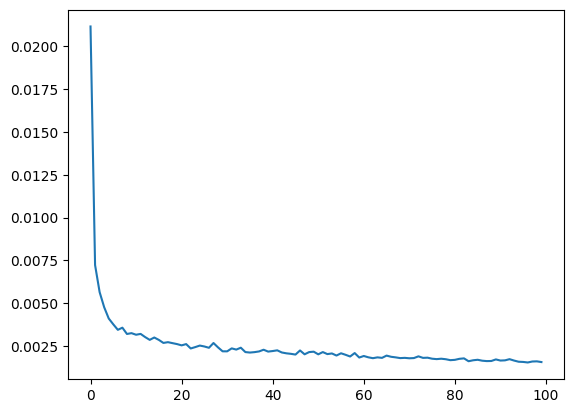

In [ ]:
losses = history.history['loss']
plt.plot(losses)
plt.show()

In [ ]:
model.evaluate(np.array(test_gray_image_z), np.array(test_rgb_image))

4/4 [==============================] - 1s 139ms/step - loss: 0.0068 - acc: 0.7084


[0.006845228839665651, 0.7083587646484375]

In [43]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(10, 10))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'blue', fontsize = 10)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 10)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 10)
    plt.imshow(predicted)
   
    plt.show()

1/1 [==============================] - 0s 162ms/step


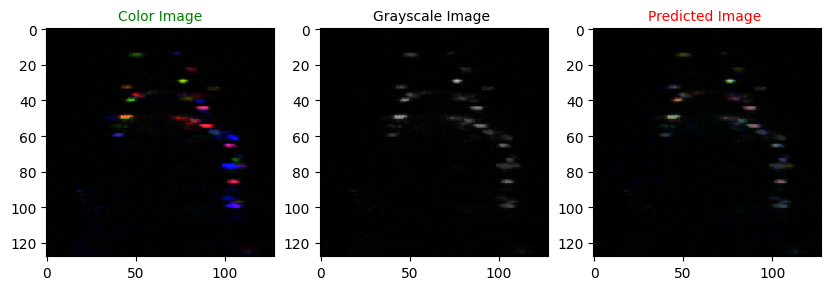

1/1 [==============================] - 0s 59ms/step


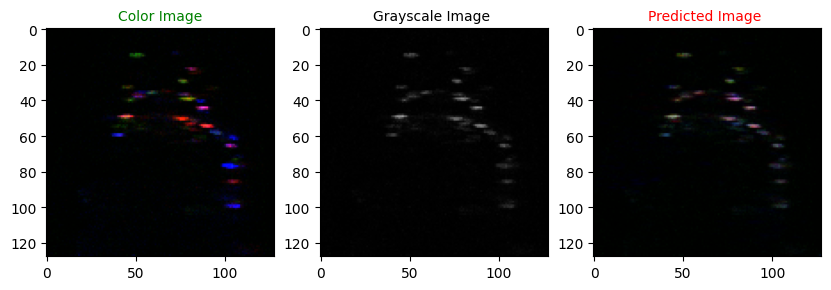

1/1 [==============================] - 0s 57ms/step


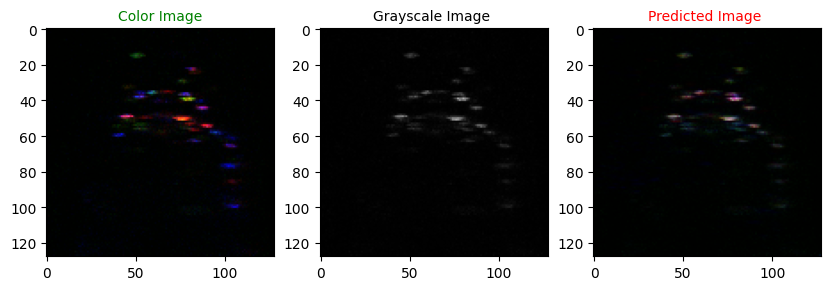

1/1 [==============================] - 0s 52ms/step


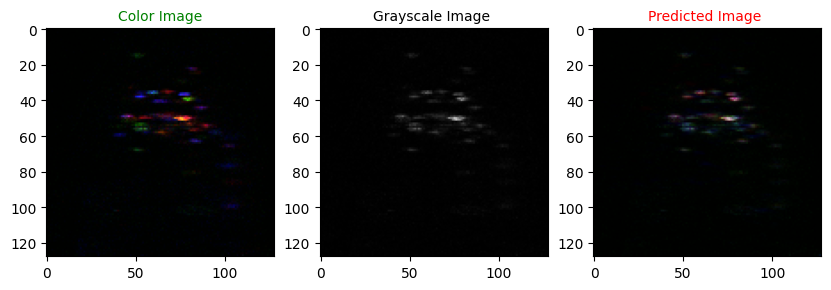

1/1 [==============================] - 0s 51ms/step


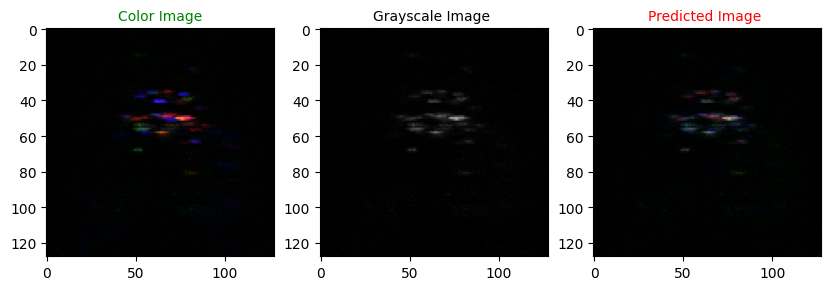

1/1 [==============================] - 0s 57ms/step


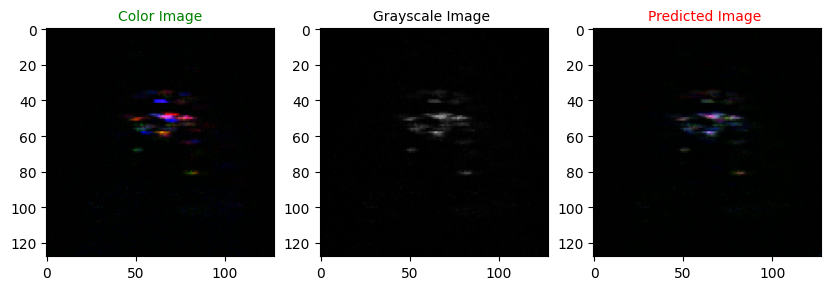

1/1 [==============================] - 0s 55ms/step


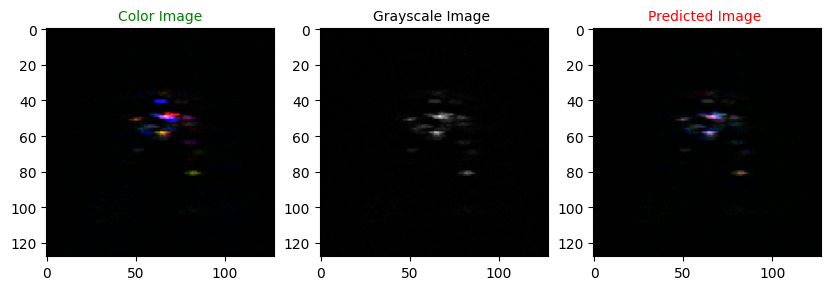

1/1 [==============================] - 0s 28ms/step


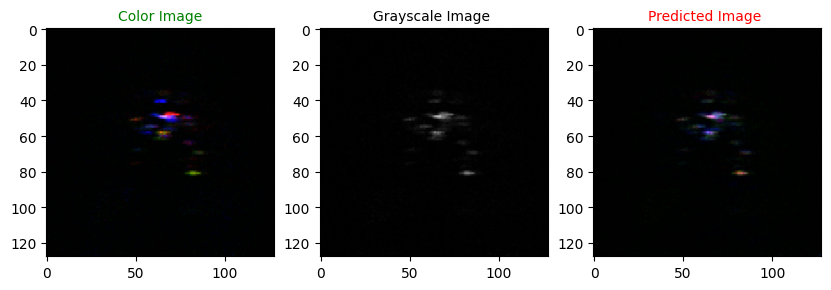

In [ ]:
for i in range(50,58):
    predicted = np.clip(model.predict(np.array(test_gray_image_z[i]).reshape(1,128, 128,4)),0.0,1.0).reshape(128, 128,3)
    plot_images(test_rgb_image[i],test_gray_image[i],predicted)


### rgb channel

In [52]:
def model2():
    inputs = layers.Input(shape= [128,128,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [53]:
model2 = model2()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_10 (Sequential)  (None, 64, 64, 128)          3584      ['input_2[0][0]']             
                                                                                                  
 sequential_11 (Sequential)  (None, 32, 32, 128)          147584    ['sequential_10[0][0]']       
                                                                                                  
 sequential_12 (Sequential)  (None, 16, 16, 256)          296192    ['sequential_11[0][0]']       
                                                                                            

In [54]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [55]:
history2 = model2.fit(np.array(train_gray_image), np.array(train_rgb_image), epochs = 100, batch_size = 8,verbose = 2)

Epoch 1/100
121/121 - 81s - loss: 0.0035 - acc: 0.4598 - 81s/epoch - 672ms/step
Epoch 2/100
121/121 - 97s - loss: 0.0026 - acc: 0.5105 - 97s/epoch - 800ms/step
Epoch 3/100
121/121 - 67s - loss: 0.0023 - acc: 0.5240 - 67s/epoch - 556ms/step
Epoch 4/100
121/121 - 21s - loss: 0.0022 - acc: 0.5347 - 21s/epoch - 176ms/step
Epoch 5/100
121/121 - 22s - loss: 0.0021 - acc: 0.5438 - 22s/epoch - 185ms/step
Epoch 6/100
121/121 - 24s - loss: 0.0019 - acc: 0.5509 - 24s/epoch - 197ms/step
Epoch 7/100
121/121 - 24s - loss: 0.0019 - acc: 0.5556 - 24s/epoch - 196ms/step
Epoch 8/100
121/121 - 24s - loss: 0.0018 - acc: 0.5574 - 24s/epoch - 196ms/step
Epoch 9/100
121/121 - 24s - loss: 0.0017 - acc: 0.5622 - 24s/epoch - 196ms/step
Epoch 10/100
121/121 - 24s - loss: 0.0017 - acc: 0.5543 - 24s/epoch - 199ms/step
Epoch 11/100
121/121 - 24s - loss: 0.0017 - acc: 0.5729 - 24s/epoch - 200ms/step
Epoch 12/100
121/121 - 24s - loss: 0.0016 - acc: 0.5784 - 24s/epoch - 202ms/step
Epoch 13/100
121/121 - 25s - loss: 0.

In [56]:
model2.evaluate(np.array(test_gray_image), np.array(test_rgb_image))

4/4 [==============================] - 1s 154ms/step - loss: 0.0065 - acc: 0.7346


[0.006523781456053257, 0.7346293330192566]

In [32]:
model2.save('models/Autoencoder.keras')

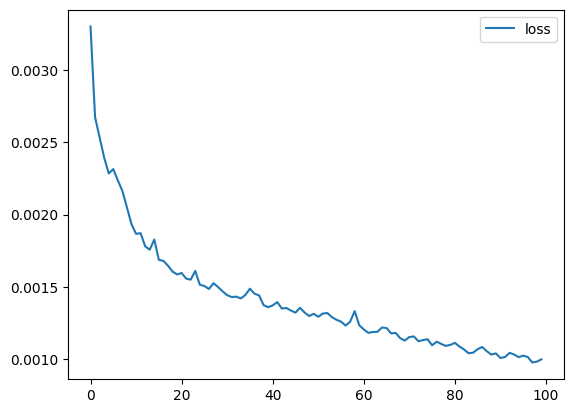

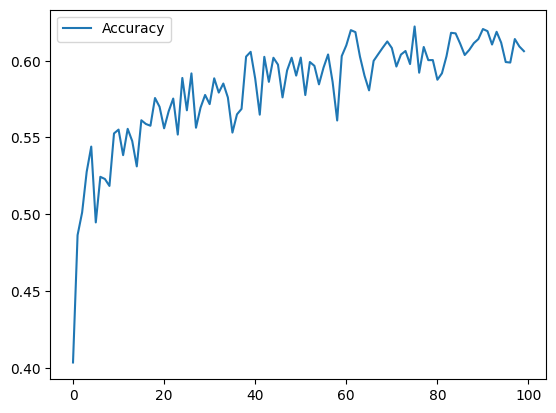

In [33]:
losses2 = history2.history['loss']
acc2 = history2.history['acc']
plt.plot(losses2, label = "loss")
plt.legend()
plt.show()
plt.plot(acc2, label = "Accuracy")
plt.legend()
plt.show()

# Check result model

### Colorize training set

1/1 [==============================] - 0s 227ms/step
SSIM Score: 0.9628549860643539


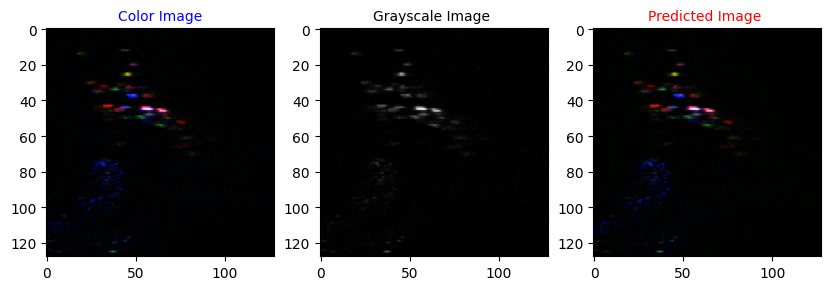

In [57]:
i=30
predicted = np.clip(model2.predict(np.array(train_gray_image[i]).reshape(1, 128, 128, 3)), 0.0, 1.0).reshape(128, 128, 3)
ssim_score= ssim(train_rgb_image[i], predicted,data_range=1, channel_axis=-1)
print('SSIM Score: '+ str(ssim_score))
plot_images(train_rgb_image[i],train_gray_image[i], predicted)


### Colorize test set

1/1 [==============================] - 0s 38ms/step
SSIM Score: 0.8297868807171018


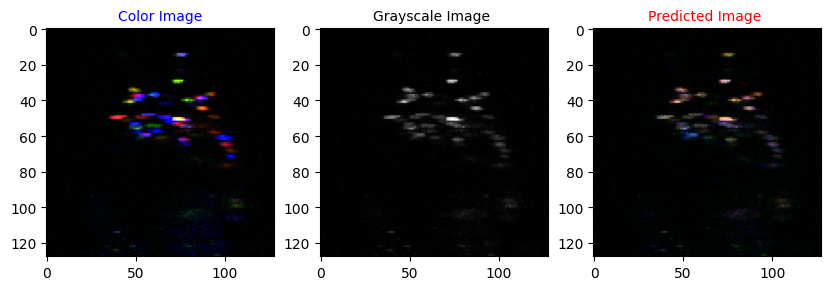

In [176]:
i=40
predicted = np.clip(model2.predict(np.array(test_gray_image[i]).reshape(1, 128, 128, 3)), 0.0, 1.0).reshape(128, 128, 3)

ssim_score= ssim(test_rgb_image[i], predicted,data_range=1, channel_axis=-1)
print('SSIM Score: '+ str(ssim_score))

plot_images(test_rgb_image[i],test_gray_image[i], predicted)


In [ ]:
acc_score = 0
test_size = len(test_gray_image)
for i in range(test_size):
    predicted = np.clip(model2.predict(np.array(test_gray_image[i]).reshape(1, 128, 128, 3)), 0.0, 1.0).reshape(128, 128, 3)
    ssim_score= ssim(test_rgb_image[i], predicted, data_range=1, channel_axis=-1)
    acc_score+=ssim_score
    
print('Average SSIM Score: '+ str(acc_score/test_size))

1/1 [==============================] - 0s 50ms/step
SSIM Score: 0.8916392369789056


### Colorize Enhanced gray image

In [34]:
model3 = model2()
model3.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 256)          296192    ['sequential_1[0][0]']        
                                                                                            

In [35]:
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [36]:
history3 = model3.fit(np.array(train_gray_image_3), np.array(train_rgb_image), epochs = 100, batch_size = 8,verbose = 2)

Epoch 1/100


121/121 - 26s - loss: 0.0043 - acc: 0.3608 - 26s/epoch - 211ms/step
Epoch 2/100
121/121 - 95s - loss: 0.0028 - acc: 0.4544 - 95s/epoch - 783ms/step
Epoch 3/100
121/121 - 72s - loss: 0.0024 - acc: 0.5076 - 72s/epoch - 592ms/step
Epoch 4/100
121/121 - 23s - loss: 0.0022 - acc: 0.5257 - 23s/epoch - 194ms/step
Epoch 5/100
121/121 - 24s - loss: 0.0021 - acc: 0.5393 - 24s/epoch - 199ms/step
Epoch 6/100
121/121 - 27s - loss: 0.0020 - acc: 0.5369 - 27s/epoch - 223ms/step
Epoch 7/100
121/121 - 27s - loss: 0.0019 - acc: 0.5460 - 27s/epoch - 224ms/step
Epoch 8/100
121/121 - 27s - loss: 0.0019 - acc: 0.5328 - 27s/epoch - 224ms/step
Epoch 9/100
121/121 - 28s - loss: 0.0018 - acc: 0.5353 - 28s/epoch - 231ms/step
Epoch 10/100
121/121 - 27s - loss: 0.0017 - acc: 0.5516 - 27s/epoch - 224ms/step
Epoch 11/100
121/121 - 28s - loss: 0.0017 - acc: 0.5461 - 28s/epoch - 231ms/step
Epoch 12/100
121/121 - 27s - loss: 0.0016 - acc: 0.5604 - 27s/epoch - 220ms/step
Epoch 13/100
121/121 - 26s - loss: 

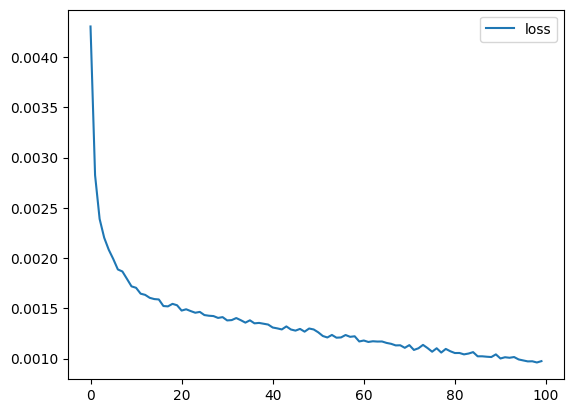

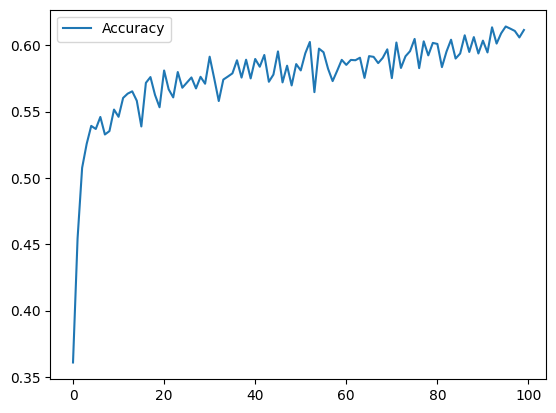

In [37]:
losses3 = history3.history['loss']
acc3 = history3.history['acc']
plt.plot(losses3, label = "loss")
plt.legend()
plt.show()
plt.plot(acc3, label = "Accuracy")
plt.legend()
plt.show()

1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM Score: 0.9649110713012677


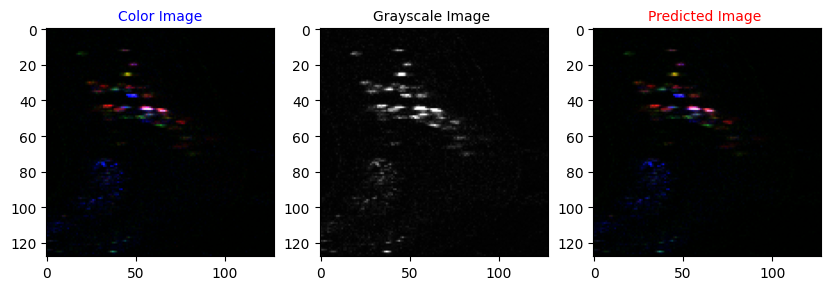

In [49]:
i=30
predicted = np.clip(model3.predict(np.array(train_gray_image_3[i]).reshape(1, 128, 128, 3)), 0.0, 1.0).reshape(128, 128, 3)
ssim_score= ssim(train_rgb_image[i], predicted,data_range=1, channel_axis=-1)
print('SSIM Score: '+ str(ssim_score))
plot_images(train_rgb_image[i],train_gray_image_3[i], predicted)

1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM Score: 0.8411515061602719


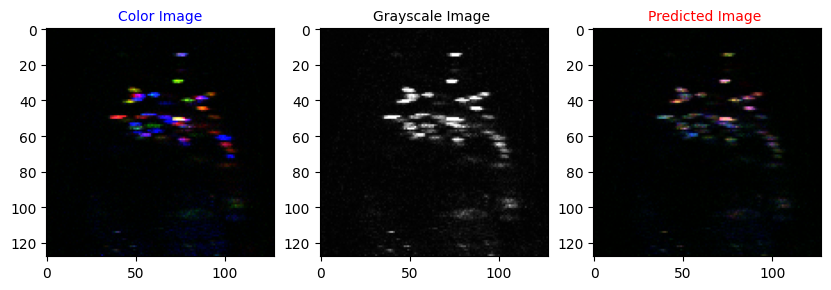

In [50]:
i=40
predicted = np.clip(model3.predict(np.array(test_gray_image_3[i]).reshape(1, 128, 128, 3)), 0.0, 1.0).reshape(128, 128, 3)

ssim_score= ssim(test_rgb_image[i], predicted,data_range=1, channel_axis=-1)
print('SSIM Score: '+ str(ssim_score))

plot_images(test_rgb_image[i],test_gray_image_3[i], predicted)


In [51]:
acc_score = 0
test_size = len(test_gray_image_3)
for i in range(test_size):
    predicted = np.clip(model3.predict(np.array(test_gray_image_3[i]).reshape(1, 128, 128, 3)), 0.0, 1.0).reshape(128, 128, 3)
    ssim_score= ssim(test_rgb_image[i], predicted, data_range=1, channel_axis=-1)
    acc_score+=ssim_score
    
print('Average SSIM Score: '+ str(acc_score/test_size))

1/1 [==============================] - 0s 48ms/step
Average SSIM Score: 0.8955242231973317


# VAE

In [140]:
class GrayscaleToRGBVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(GrayscaleToRGBVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output range [0, 1] for RGB
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        x = x.reshape(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decoding
        x = self.fc_decoder(z)
        x = x.reshape(x.size(0), 128, 16, 16)  # Reshape to feature map
        x = self.decoder(x)
        return x, mu, logvar

In [92]:
def loss_fn(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= recon_x.size(0)
        return BCE + KLD, BCE, KLD

In [61]:
def grayscale_to_rgb_loss(predictions, targets, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE for RGB values)
    recon_loss = nn.MSELoss()(predictions, targets)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /= predictions.size(0)  # Normalize by batch size

    # Total loss
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss


c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/200], Train Loss: 3917.5382, Test Loss: 2701.1996


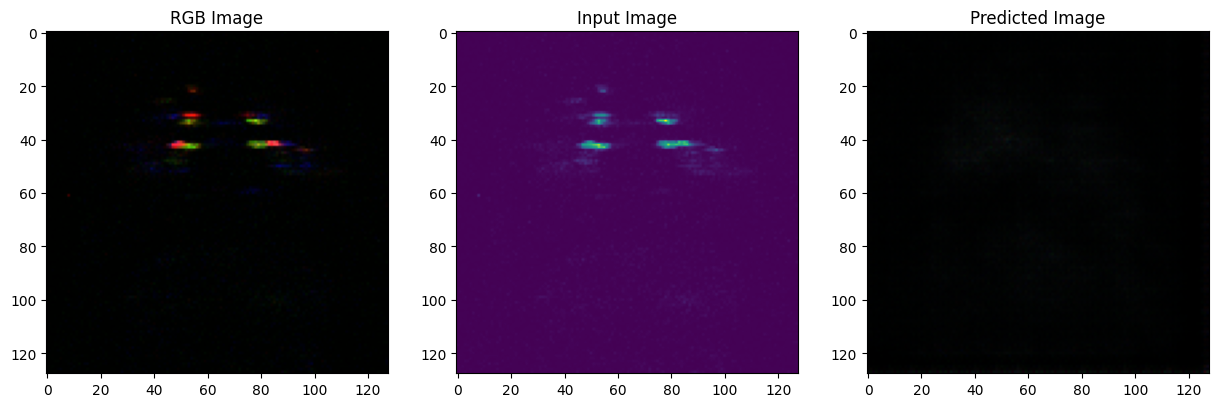

Epoch [2/200], Train Loss: 1292.3094, Test Loss: 2639.8593
Epoch [3/200], Train Loss: 1251.8857, Test Loss: 2664.5299
Epoch [4/200], Train Loss: 1227.4066, Test Loss: 2612.5008
Epoch [5/200], Train Loss: 1206.9055, Test Loss: 2604.7767
Epoch [6/200], Train Loss: 1190.1325, Test Loss: 2578.2596
Epoch [7/200], Train Loss: 1182.9841, Test Loss: 2585.9759
Epoch [8/200], Train Loss: 1169.3047, Test Loss: 2566.6026
Epoch [9/200], Train Loss: 1159.6135, Test Loss: 2607.3983
Epoch [10/200], Train Loss: 1151.6533, Test Loss: 2587.3856
Epoch [11/200], Train Loss: 1140.0745, Test Loss: 2571.8559
Epoch [12/200], Train Loss: 1140.4274, Test Loss: 2584.6709
Epoch [13/200], Train Loss: 1124.3653, Test Loss: 2608.9526
Epoch [14/200], Train Loss: 1118.9499, Test Loss: 2620.6651
Epoch [15/200], Train Loss: 1120.4746, Test Loss: 2598.7659
Epoch [16/200], Train Loss: 1108.6953, Test Loss: 2598.1373
Epoch [17/200], Train Loss: 1104.8056, Test Loss: 2612.9620
Epoch [18/200], Train Loss: 1104.7955, Test Loss

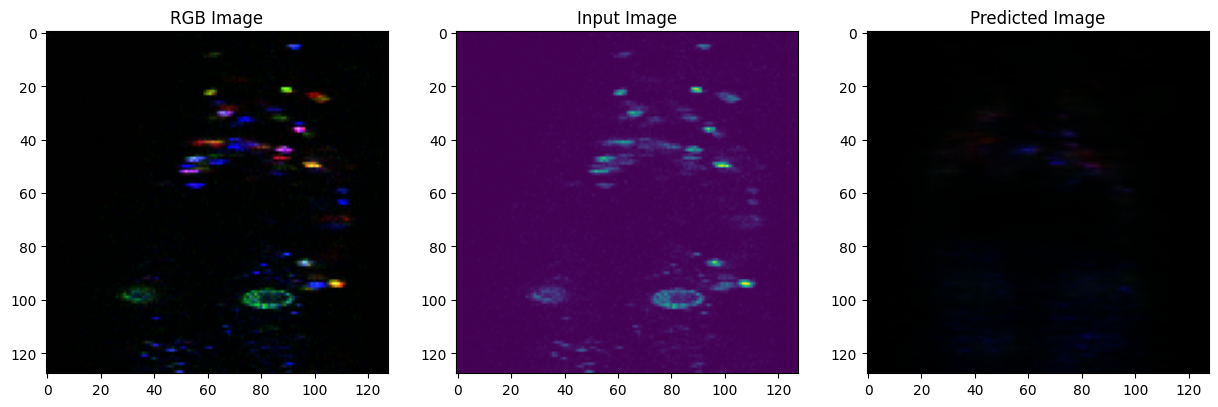

Epoch [52/200], Train Loss: 1066.4095, Test Loss: 2567.5437
Epoch [53/200], Train Loss: 1059.2262, Test Loss: 2563.1742
Epoch [54/200], Train Loss: 1057.0312, Test Loss: 2561.9820
Epoch [55/200], Train Loss: 1056.4160, Test Loss: 2556.1383
Epoch [56/200], Train Loss: 1060.2228, Test Loss: 2609.1236
Epoch [57/200], Train Loss: 1060.4852, Test Loss: 2612.5693
Epoch [58/200], Train Loss: 1061.4036, Test Loss: 2563.7925
Epoch [59/200], Train Loss: 1057.0871, Test Loss: 2571.9433
Epoch [60/200], Train Loss: 1057.7085, Test Loss: 2583.9387
Epoch [61/200], Train Loss: 1071.4498, Test Loss: 2571.5187
Epoch [62/200], Train Loss: 1057.7187, Test Loss: 2568.5806
Epoch [63/200], Train Loss: 1054.4457, Test Loss: 2553.2069
Epoch [64/200], Train Loss: 1052.8790, Test Loss: 2566.9918
Epoch [65/200], Train Loss: 1052.3521, Test Loss: 2561.6006
Epoch [66/200], Train Loss: 1053.7220, Test Loss: 2587.3390
Epoch [67/200], Train Loss: 1060.4797, Test Loss: 2551.6361
Epoch [68/200], Train Loss: 1057.2215, T

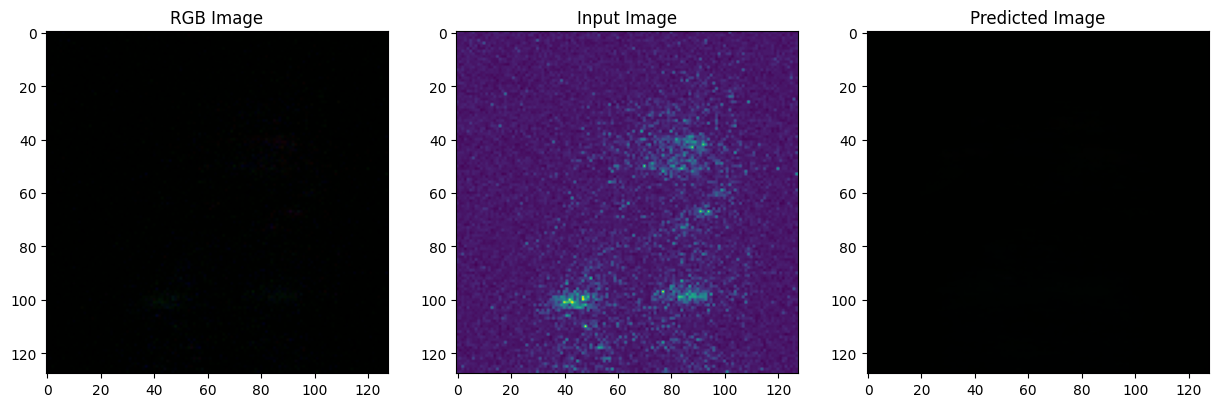

Epoch [102/200], Train Loss: 1047.8531, Test Loss: 2569.7796
Epoch [103/200], Train Loss: 1047.3329, Test Loss: 2580.9081
Epoch [104/200], Train Loss: 1047.8824, Test Loss: 2567.7677
Epoch [105/200], Train Loss: 1047.4785, Test Loss: 2556.4860
Epoch [106/200], Train Loss: 1048.0811, Test Loss: 2559.9214
Epoch [107/200], Train Loss: 1047.7336, Test Loss: 2579.9759
Epoch [108/200], Train Loss: 1048.8548, Test Loss: 2567.3330
Epoch [109/200], Train Loss: 1048.7216, Test Loss: 2554.4066
Epoch [110/200], Train Loss: 1047.1791, Test Loss: 2582.0204
Epoch [111/200], Train Loss: 1047.5681, Test Loss: 2562.4974
Epoch [112/200], Train Loss: 1046.5100, Test Loss: 2559.1752
Epoch [113/200], Train Loss: 1046.3044, Test Loss: 2581.1682
Epoch [114/200], Train Loss: 1046.8336, Test Loss: 2574.2376
Epoch [115/200], Train Loss: 1045.5226, Test Loss: 2568.8590
Epoch [116/200], Train Loss: 1046.0972, Test Loss: 2555.0348
Epoch [117/200], Train Loss: 1046.5213, Test Loss: 2553.0706
Epoch [118/200], Train L

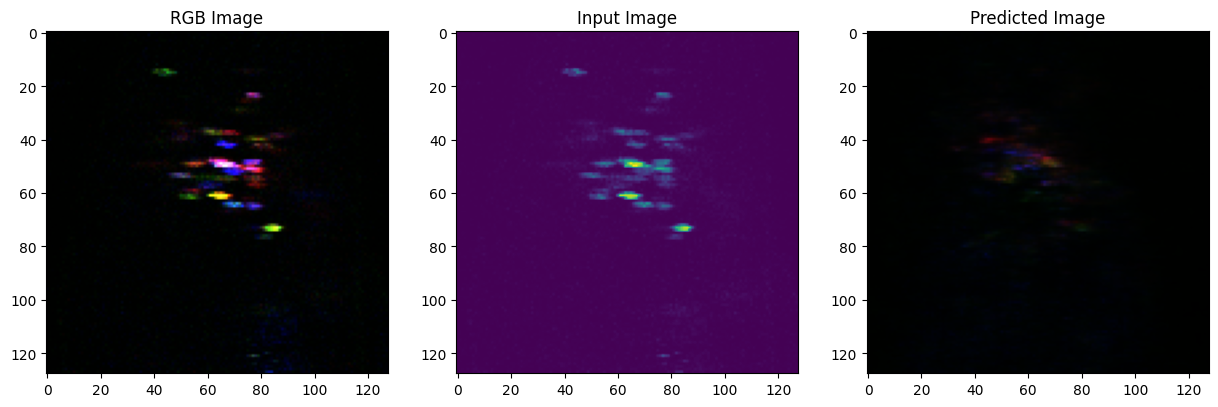

Epoch [152/200], Train Loss: 1040.6955, Test Loss: 2568.0667
Epoch [153/200], Train Loss: 1040.7070, Test Loss: 2567.2459
Epoch [154/200], Train Loss: 1041.5376, Test Loss: 2565.9118
Epoch [155/200], Train Loss: 1042.1203, Test Loss: 2594.9587
Epoch [156/200], Train Loss: 1042.7284, Test Loss: 2569.8405
Epoch [157/200], Train Loss: 1040.4618, Test Loss: 2574.4635
Epoch [158/200], Train Loss: 1039.6603, Test Loss: 2574.7702
Epoch [159/200], Train Loss: 1039.7300, Test Loss: 2582.0276
Epoch [160/200], Train Loss: 1040.4465, Test Loss: 2568.1196
Epoch [161/200], Train Loss: 1039.7039, Test Loss: 2578.8695
Epoch [162/200], Train Loss: 1039.1741, Test Loss: 2565.7083
Epoch [163/200], Train Loss: 1039.9129, Test Loss: 2574.7390
Epoch [164/200], Train Loss: 1039.9095, Test Loss: 2576.7889
Epoch [165/200], Train Loss: 1040.5674, Test Loss: 2572.2480
Epoch [166/200], Train Loss: 1040.2223, Test Loss: 2591.4671
Epoch [167/200], Train Loss: 1039.5156, Test Loss: 2572.1827
Epoch [168/200], Train L

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GrayscaleToRGBVAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
test_losses = []
beta = 1.0
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Train phase
    for grayscale, rgb in train_loader:
        grayscale, rgb = grayscale.permute(0, 3, 1, 2).to(device), rgb.permute(0, 3, 1, 2).to(device)
        
        # Forward pass
        
        predictions, mu, logvar = model(grayscale)

        # Compute loss
        total_loss, recon_loss, kl_loss = loss_fn(predictions, rgb, mu, logvar)

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

    train_losses.append(train_loss /len(train_loader.dataset))
    
    # Testing phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for grayscale, rgb in test_loader:
            grayscale, rgb = grayscale.permute(0, 3, 1, 2).to(device), rgb.permute(0, 3, 1, 2).to(device)

            # Forward pass
            predictions, mu, logvar = model(grayscale)

            # Compute losses
            total_loss, recon_loss, kl_loss = loss_fn(predictions, rgb, mu, logvar)

            test_loss += total_loss.item()

    test_losses.append(test_loss / len(test_loader.dataset))

    # Print metrics
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
        
    if epoch%50==0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        # Plot the pdf, cdf & image before equalize
        ax3.set_title("Predicted Image")
        ax3.imshow(predictions.cpu().detach()[0].permute(1,2,0).numpy())
        ax2.set_title("Input Image")
        ax2.imshow(grayscale.cpu().detach()[0].permute(1,2,0)[:,:,0].numpy())
        ax1.set_title("RGB Image")
        ax1.imshow(rgb.cpu().detach()[0].permute(1,2,0).numpy())
        plt.show()